In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [48]:
%%time

# Load train data
chunks = pd.read_json('data_json/train.jsonl', lines=True, chunksize=100_000)
train = pd.DataFrame()
for i, chunk in enumerate(chunks):
    event_dict = {
        'session': [],
        'aid':     [],
        'ts':      [],
        'type':    []
    }

    if i >= 2:
        break
    for session, events in zip(chunk['session'].tolist(), \
                               chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    train = pd.concat([train, chunk_session])

CPU times: user 19.9 s, sys: 13.8 s, total: 33.7 s
Wall time: 38.3 s


In [49]:
train = train.reset_index(drop=True)
display(train)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
10285556,199999,928064,1659336408967,clicks
10285557,199999,849970,1659336449078,clicks
10285558,199999,1052480,1659336547035,clicks
10285559,199999,487255,1659336561116,clicks


In [50]:
# train.ts = pd.to_datetime(train.ts, unit='ms')
train.ts = pd.to_datetime(train.ts * 1e6)
display(train)

,session,aid,ts,type
0,0,1517085,2022-07-31 22:00:00.024999936,clicks
1,0,1563459,2022-07-31 22:01:44.511000064,clicks
2,0,1309446,2022-08-01 15:23:59.425999872,clicks
3,0,16246,2022-08-01 15:28:39.996999936,clicks
4,0,1781822,2022-08-01 15:31:11.344000000,clicks
...,...,...,...,...
10285556,199999,928064,2022-08-01 06:46:48.967000064,clicks
10285557,199999,849970,2022-08-01 06:47:29.078000128,clicks
10285558,199999,1052480,2022-08-01 06:49:07.035000064,clicks
10285559,199999,487255,2022-08-01 06:49:21.116000000,clicks


In [52]:
print(train['type'].unique())

['clicks' 'carts' 'orders']


In [54]:
type_to_num = {'clicks': 0,
               'carts': 1,
               'orders': 2}
train['type'] = train['type'].map(type_to_num)
display(train)

,session,aid,ts,type
0,0,1517085,2022-07-31 22:00:00.024999936,0
1,0,1563459,2022-07-31 22:01:44.511000064,0
2,0,1309446,2022-08-01 15:23:59.425999872,0
3,0,16246,2022-08-01 15:28:39.996999936,0
4,0,1781822,2022-08-01 15:31:11.344000000,0
...,...,...,...,...
10285556,199999,928064,2022-08-01 06:46:48.967000064,0
10285557,199999,849970,2022-08-01 06:47:29.078000128,0
10285558,199999,1052480,2022-08-01 06:49:07.035000064,0
10285559,199999,487255,2022-08-01 06:49:21.116000000,0


In [55]:
print('Train min date and max date are:', train.ts.min(), train.ts.max())
print('We will truncate train data to begin Aug 1st, 2022')
train = train.loc[train.ts >= pd.to_datetime('2022-08-01')]

Train min date and max date are: 2022-07-31 22:00:00.024999936 2022-08-28 21:59:59.940999936
We will truncate train data to begin Aug 1st, 2022


In [56]:
%%time
# compute dat and hour of activity
train['day'] = train.ts.dt.day
train['hour'] = train.ts.dt.hour
train = train.reset_index(drop=True)

tmp = train.groupby('session').aid.agg('count').rename('n')
train = train.merge(tmp, on='session')

CPU times: user 692 ms, sys: 404 ms, total: 1.1 s
Wall time: 1.18 s


In [57]:
frequent_users = train.loc[train.n>40, 'session'].unique()
print(f"There are {len(frequent_users)} users whom each have over 40 item interactions in train data.")

There are 65650 users whom each have over 40 item interactions in train data.


In [58]:
# Compute user real sessions
train.ts = train.ts.astype('int64') / 1e6
train = train.sort_values(['session', 'ts']).reset_index(drop=True)
train['d'] = train.ts.diff()
train.loc[train.session.diff()!=0, 'd'] = 0
# Identity real user sessions when we see 2 hour pause in activity
train.d = (train.d > 60*60*2).astype('int8').fillna(0)
train['d'] = train.groupby('session').d.cumsum()

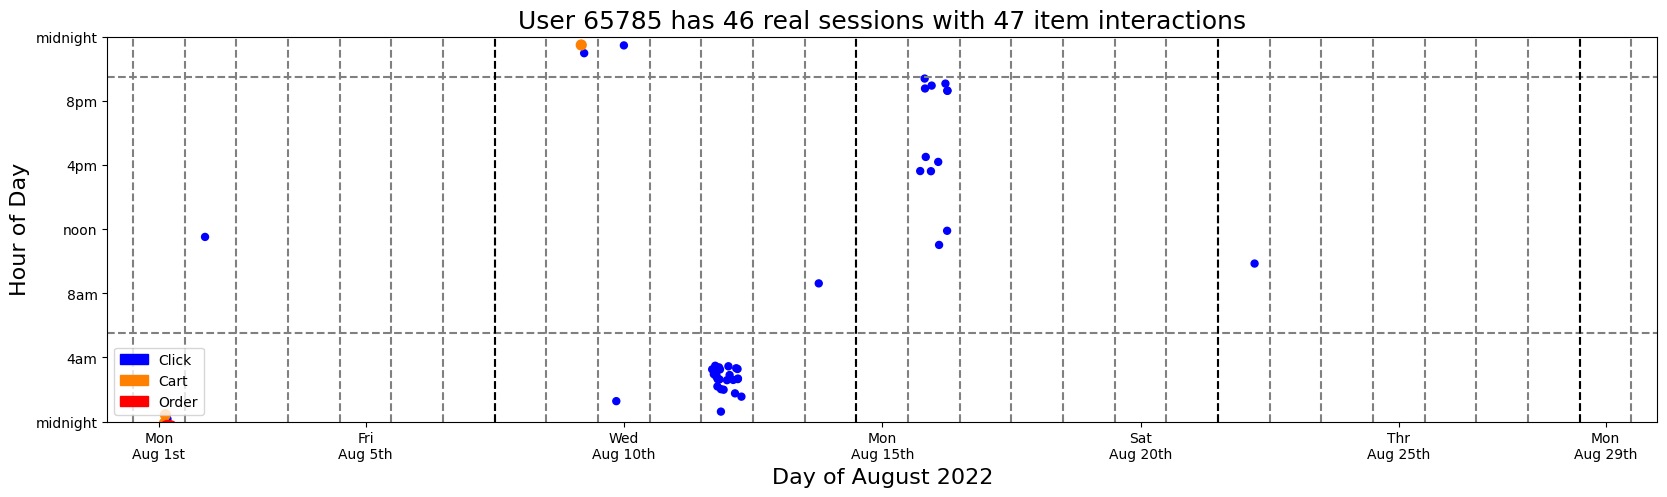

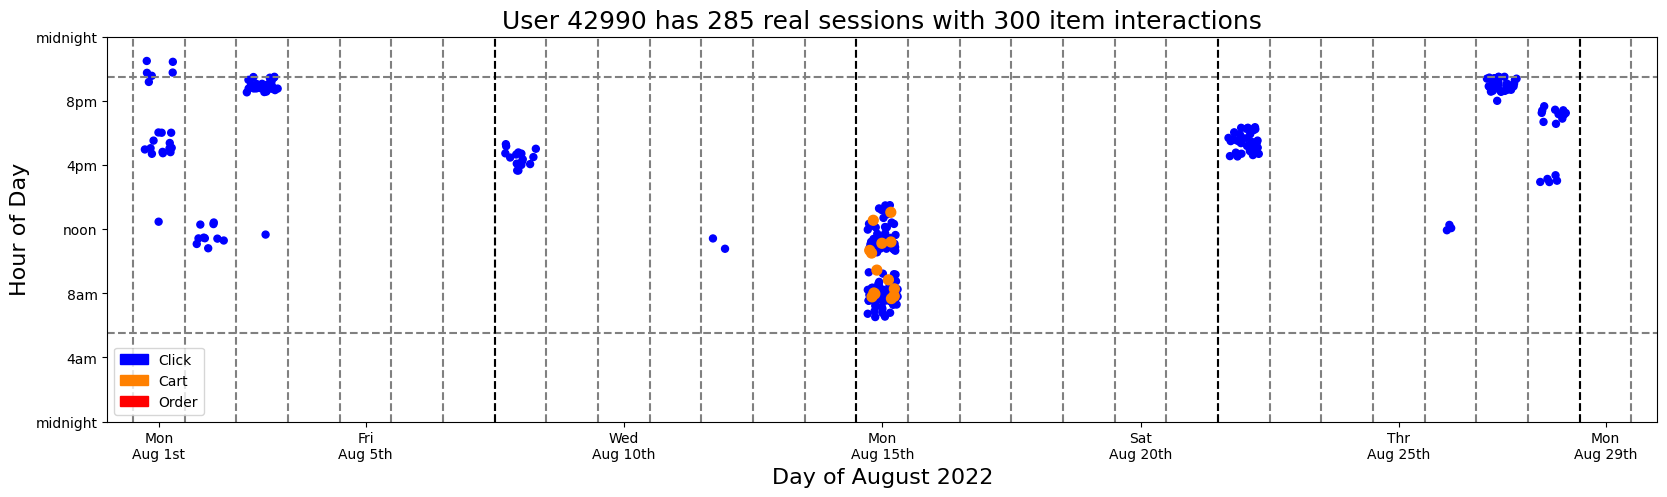

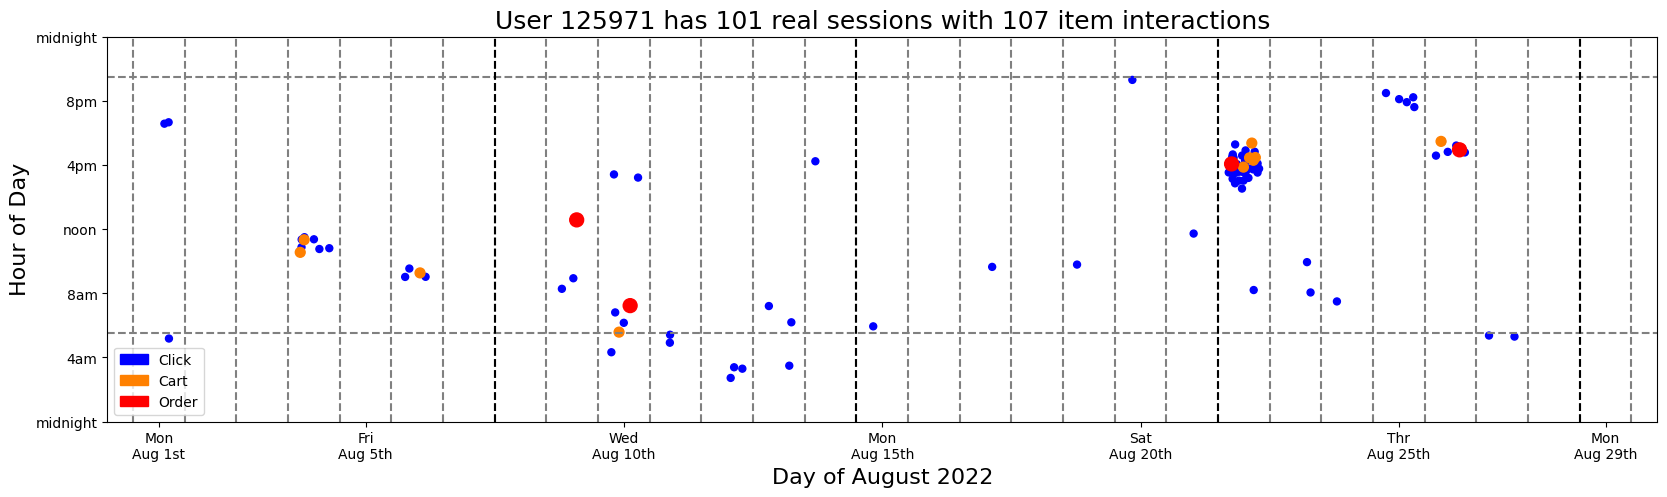

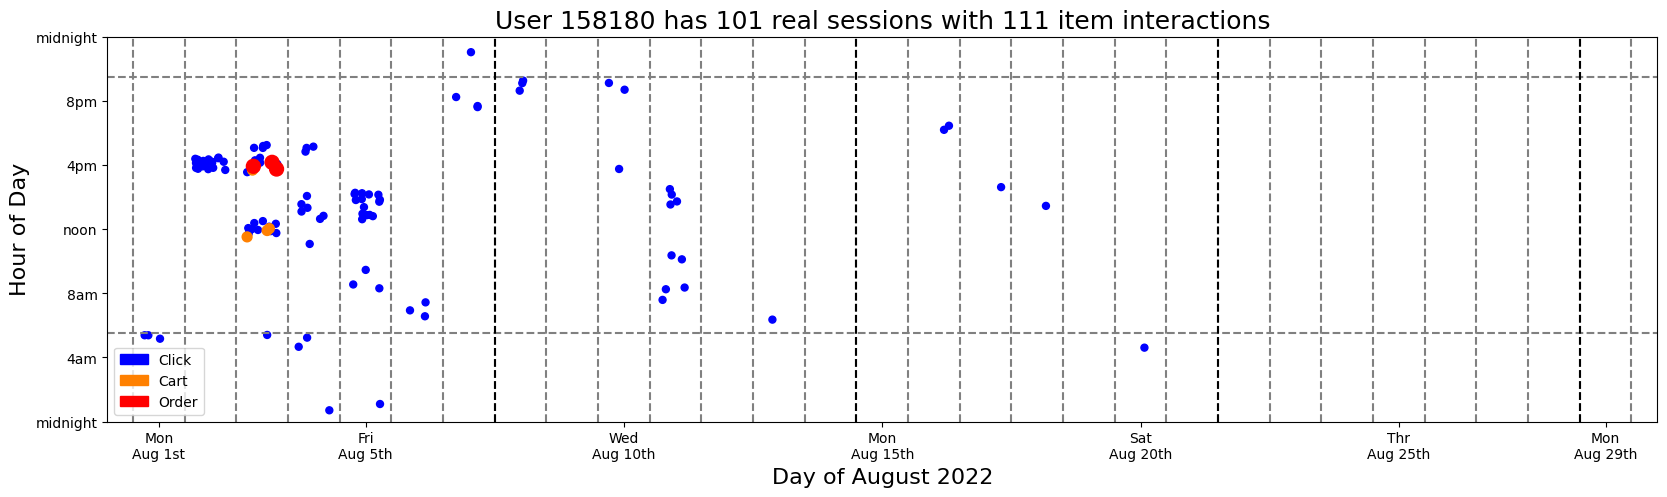

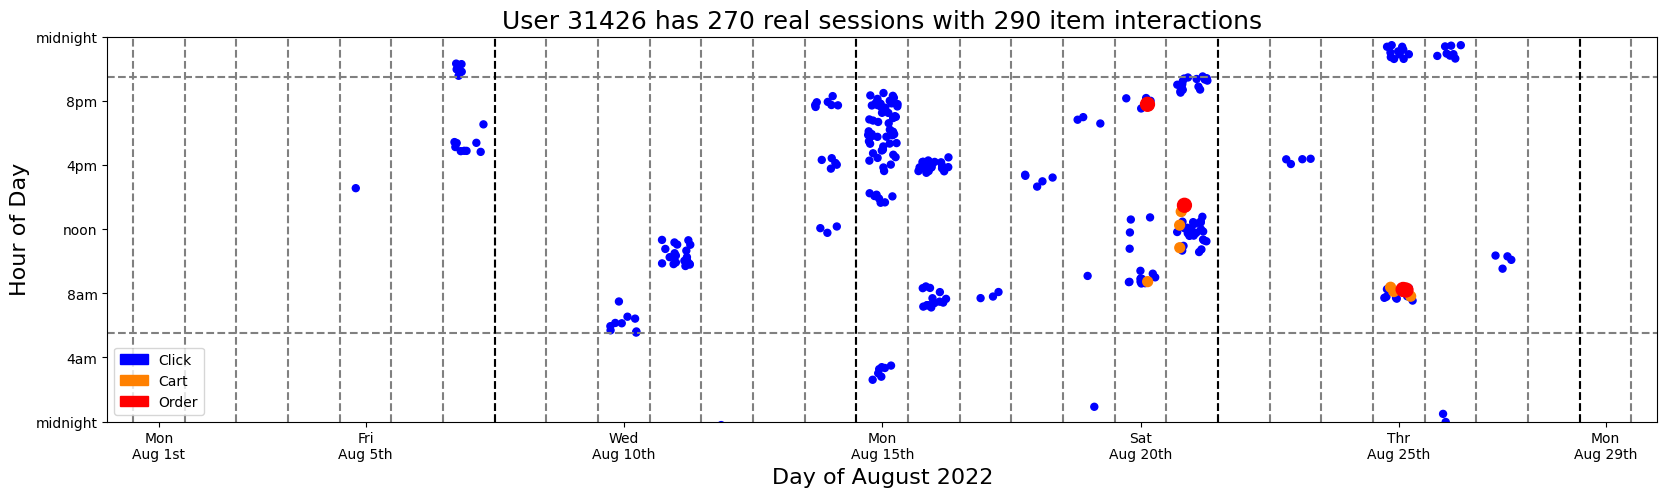

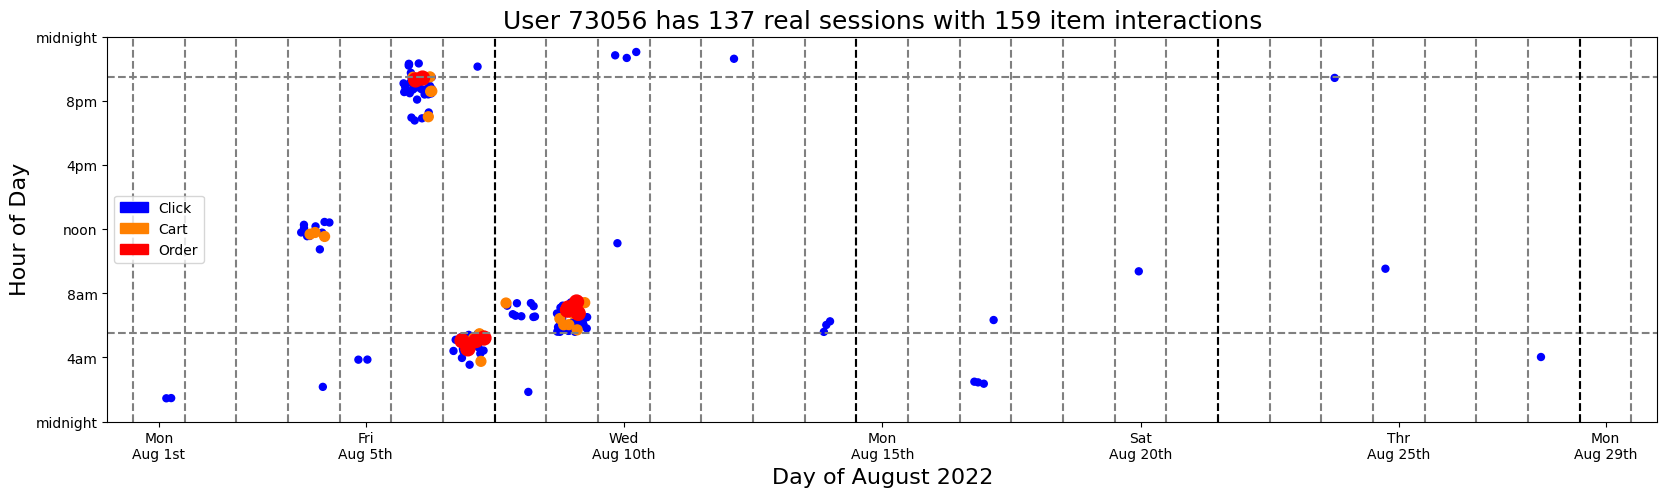

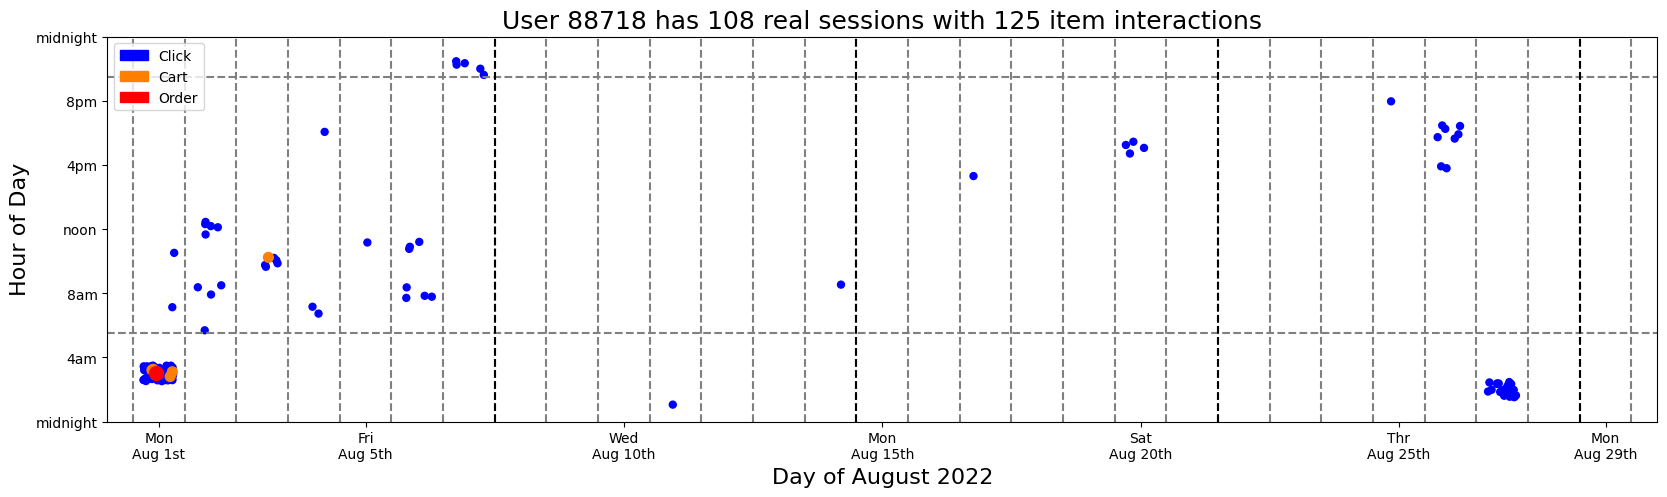

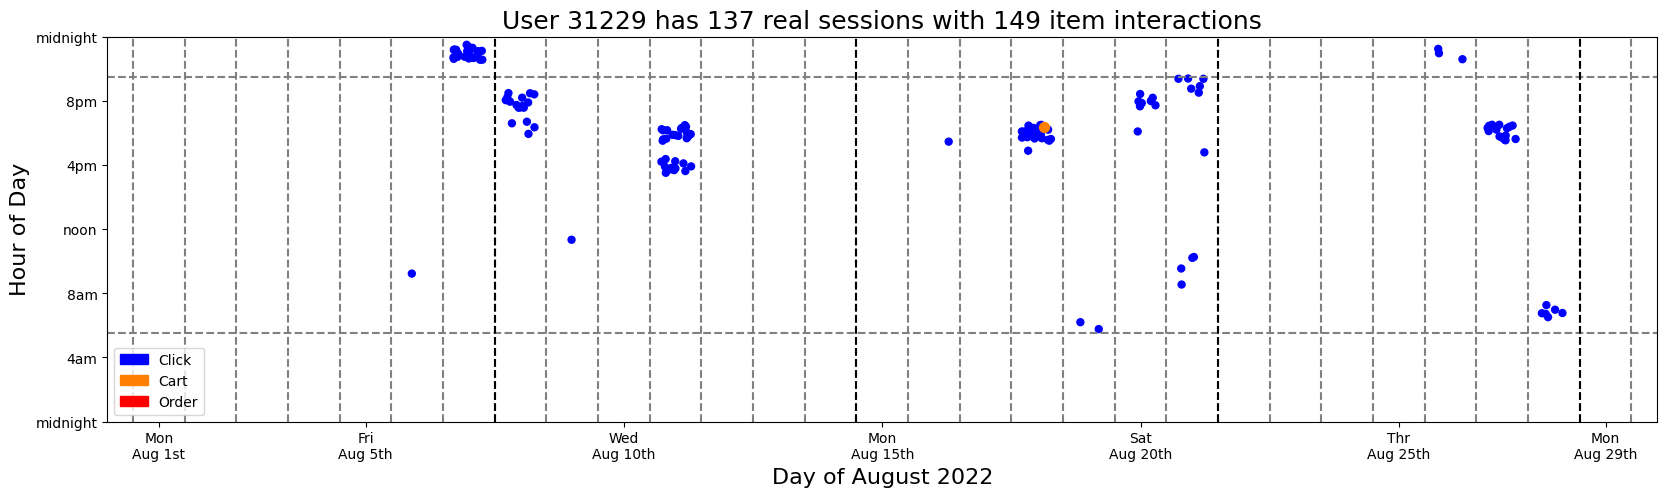

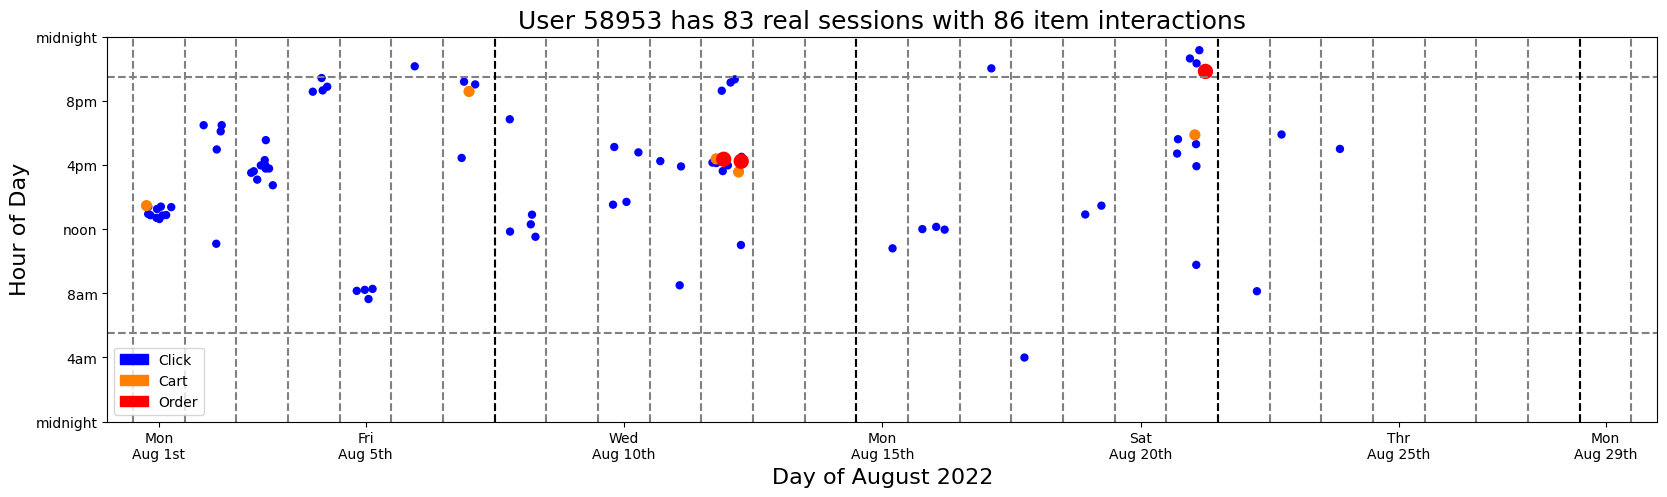

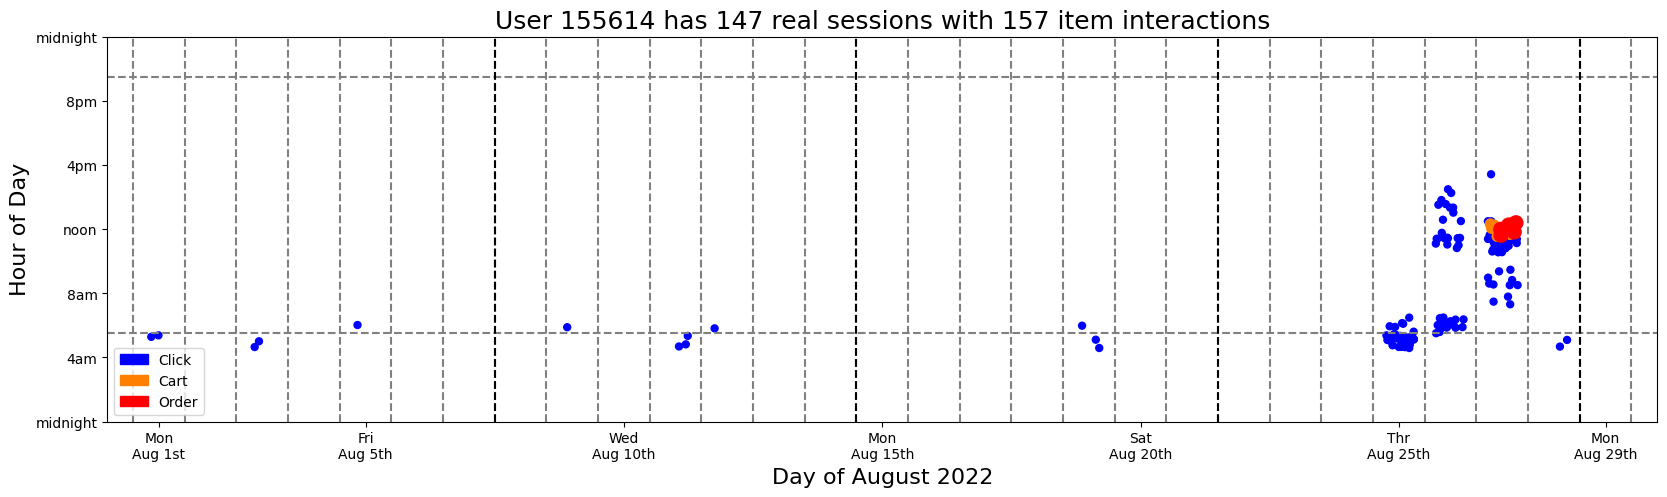

In [59]:
#Display user activity
colors = np.array([(0,0,1),(1,0.5,0),(1,0,0)])

for k in range(10):
    u = np.random.choice(frequent_users)
    tmp = train.loc[train.session==u]

    ss = tmp.d.max()+1
    ii = len(tmp)
    
    plt.figure(figsize=(20,5))
    for j in [0,1,2]:
        s = 25
        if j==1: s=50
        elif j==2: s=100
        tmp2 = tmp.loc[tmp['type']==j]
        xx = np.random.uniform(-0.3,0.3,len(tmp2))
        yy = np.random.uniform(-0.5,0.5,len(tmp2))
        plt.scatter(tmp2.day.values+xx, tmp2.hour.values+yy, s=s, c=colors[tmp2['type'].values])
    plt.ylim((0,24))
    plt.xlim((0,30))
    c1 = mpatches.Patch(color=colors[0], label='Click')
    c2 = mpatches.Patch(color=colors[1], label='Cart')
    c3 = mpatches.Patch(color=colors[2], label='Order')
    plt.plot([0,30],[6-0.5,6-0.5],'--',color='gray')
    plt.plot([0,30],[21+0.5,21+0.5],'--',color='gray')
    for k in range(0,30):
        plt.plot([k+0.5,k+0.5],[0,24],'--',color='gray')
    for k in range(1,5):
        plt.plot([7*k+0.5,7*k+0.5],[0,24],'--',color='black')
    plt.legend(handles=[c1,c2,c3])
    plt.xlabel('Day of August 2022',size=16)
    plt.xticks([1,5,10,15,20,25,29],['Mon\nAug 1st','Fri\nAug 5th','Wed\nAug 10th','Mon\nAug 15th','Sat\nAug 20th','Thr\nAug 25th','Mon\nAug 29th'])
    plt.ylabel('Hour of Day',size=16)
    plt.yticks([0,4,8,12,16,20,24],['midnight','4am','8am','noon','4pm','8pm','midnight'])
    plt.title(f'User {u} has {ss} real sessions with {ii} item interactions',size=18)
    plt.show()
    print('\n\n')